kvasir version 2 dataset split into neg/pos and trained using keras resnet50 witouth augmentation or ds normalization. Used to take time measurements after offloading functions to utils folder. Prelimitary results: loading data-code runs 1380% slower (37 seconds) comparedto binary_resnet50.ipynb which loads data in 2.5 seconds

### Loading images
https://www.tensorflow.org/tutorials/load_data/images

In [1]:
import time
start_time = time.time()

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import IPython.display as display
import numpy as np
import os
import sys
import pathlib
import matplotlib.pyplot as plt

AUTOTUNE = tf.data.experimental.AUTOTUNE
sys.path.append('/home/henriklg/master-thesis/code/utils')
from dataprep import create_dataset, print_class_info, show_image

from PIL import Image
from glob import glob
from os.path import join

%matplotlib inline

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
MODEL = 'resnet50'
DS_INFO = 'binary'
NUM_EPOCHS = 2
BATCH_SIZE = 64
IMG_HEIGHT = 64 #224
IMG_WIDTH = 64

NUM_CHANNELS = 3
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS)

# epoch x batch_size x img_size _ dataset-type _ model
model_name = '{}x{}x{}_{}_{}'.format(NUM_EPOCHS, BATCH_SIZE, IMG_WIDTH, DS_INFO, MODEL)

# data_dir = pathlib.Path('/mnt/sdb/kvasir-dataset-v2/')
data_dir = pathlib.Path('/home/henriklg/master-thesis/data/kvasir-dataset-v2/')
outcasts = []
neg_class = ['polyps']
neg_pos_names = ['Negative', 'Positive']
NUM_CLASSES = 2

In [5]:
ds, DS_SIZE, class_names, pos_class = create_dataset(data_dir, binary=True, neg_class=neg_class, verbose=True)

Positive class names:  ['normal-cecum', 'normal-pylorus', 'esophagitis', 'normal-z-line', 'ulcerative-colitis', 'dyed-resection-margins', 'dyed-lifted-polyps']
Negative class names:  ['polyps']



In [6]:
print_class_info(class_names, data_dir, pos_class, neg_class)

Positive class names:
        - normal-cecum
        - normal-pylorus
        - esophagitis
        - normal-z-line
        - ulcerative-colitis
        - dyed-resection-margins
        - dyed-lifted-polyps
Negative class names:
        - polyps

Negative samples:  1000 | 12.50%
Positive samples:  7000 | 87.50%

Total number of images: 8000


Set up pipeline for loading images from given list of paths

In [7]:
def get_label_int(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    bc = parts[-2] == pos_class
    nz_cnt = tf.math.count_nonzero(bc)
    if (nz_cnt > 0):
        return tf.reshape(tf.dtypes.cast(tf.fill([1, 1], value=1), tf.uint8),[-1])
    return tf.reshape(tf.dtypes.cast(tf.fill([1, 1], value=0), tf.uint8),[-1])

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
    label = get_label_int(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

labeled_ds = ds.map(process_path, num_parallel_calls=AUTOTUNE)

Showing an example image/label pair

<Figure size 432x288 with 0 Axes>

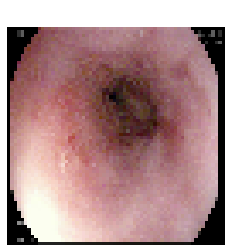

In [8]:
show_image(labeled_ds.take(1), neg_pos_names)

In [9]:
end_time = time.time()
print ("Time to run code: ",end_time-start_time)

Time to run code:  37.44660401344299


### Splitting into training, test and validation data

In [ ]:
train_size = int(0.7 * DS_SIZE)
val_size = int(0.15 * DS_SIZE)
test_size = int(0.15 * DS_SIZE)

shuffled_ds = labeled_ds#.shuffle(buffer_size=10000)

train_ds = shuffled_ds.take(train_size)
test_ds = shuffled_ds.skip(train_size)
val_ds = test_ds.skip(val_size)
test_ds = test_ds.take(test_size)

In [ ]:
# Print info about the dataset split
def get_size(ds):
    return tf.data.experimental.cardinality(ds).numpy()

print ("{:32} {:>5}".format("Full dataset sample size:", get_size(shuffled_ds)))
print ("{:32} {:>5}".format("Train dataset sample size:", get_size(train_ds)))
print ("{:32} {:>5}".format("Test dataset sample size:", get_size(test_ds)))
print ("{:32} {:>5}".format("Validation dataset sample size:", get_size(val_ds)))

In [ ]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=3000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
      if isinstance(cache, str):
        ds = ds.cache(cache)
      else:
        ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

# Create training, test and validation dataset
train_ds = prepare_for_training(train_ds, cache="./cache/train_{}.tfcache".format(IMG_WIDTH))
test_ds = prepare_for_training(test_ds, cache="./cache/test_{}.tfcache".format(IMG_WIDTH))
val_ds = prepare_for_training(val_ds, cache="./cache/val_{}.tfcache".format(IMG_WIDTH))

## Training
https://adventuresinmachinelearning.com/transfer-learning-tensorflow-2/

In [ ]:
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.keras import layers

In [ ]:
res_net = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=IMG_SIZE)

In [ ]:
res_net.trainable = False

global_average_layer = layers.GlobalAveragePooling2D()
output_layer = layers.Dense(1, activation='sigmoid')

tl_model = tf.keras.Sequential([
        res_net,
        global_average_layer,
        output_layer])

In [ ]:
tl_model.summary()

In [ ]:
tl_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy'])

callbacks = [tf.keras.callbacks.TensorBoard(log_dir='./logs/transfer_learning_model', update_freq='batch')]

In [ ]:
history = tl_model.fit(
        train_ds,
        steps_per_epoch = train_size // BATCH_SIZE,
        epochs = NUM_EPOCHS,
        validation_data = test_ds,
        validation_steps = test_size // BATCH_SIZE,
        validation_freq = 1,
        callbacks = callbacks)

`Keras`
Save/load the model

In [ ]:
# tl_model.save('models/{}.h5'.format(model_name))
tl_model = tf.keras.models.load_model('models/{}.h5'.format(model_name))

## Validate the results

`Tensorboard`

In [ ]:
# Clear any logs from previous runs (move to .old instead?)
# !rm -rf ./logs/

In [ ]:
# Start tensorboard
%tensorboard --logdir logs

In [ ]:
# !kill 20058

In [ ]:
result = tl_model.evaluate(
            val_ds,
            steps = val_size//BATCH_SIZE)

## Predict new samples

In [ ]:
# Fetch one batch
images, labels = next(iter(val_ds))

# Convert from tensor to numpy array
images = images.numpy()
labels = labels.numpy()

In [ ]:
# Get a random image and label
idx = np.random.randint(0, BATCH_SIZE)
idx = 4
image = images[idx]
label = labels[idx]

# Predict one image
result = tl_model.predict(np.expand_dims(image, axis=0))[0][0]

print ("True label:", class_names[label[0]])
print ('Probabibity of Positive: {:.5f}%'.format((result)*100))

plt.figure()
plt.imshow(image)
plt.axis('off');

In [ ]:
# Predict one batch
results = tl_model.predict(images)

print ('{:3}  {:7}  {:3}%'.format('idx', 'true_label', 'pred_prob'))
print ('---  ---------   ----------')
idx = 0
for result in results:
    true_label = class_names[labels[idx]][0]
    pred_prob = result[0]
    print ('{:3}  {:10}  {:05f}%'.format(idx, true_label, pred_prob))
    idx += 1